## NYT Crossword Stats: Basic Data Cleaning and Analysis

Using the crossword scraper, I've extracted my 2018 stats from the NYT crossword website. Now, I want to set up a basic analysis pipeline to clean and visualize the data. Once done, I'll pull in stats from other years as well and set up some more complex visualizations.

## Part 0: Setup

In [244]:
#### import packages ####
# basic
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, timezone
import calendar
import seaborn as sns
import math

# custom


In [29]:
# data parsing functions
def nan_datetime_fromtimestamp(x):
    '''x = seconds since epoch'''
    try:
        return datetime.fromtimestamp(x)
    except ValueError:
        return None

def get_weekday(dt_obj, numeric=True):
    if numeric:
        return dt_obj.weekday()
    else:
        return calendar.day_name[dt_obj.weekday()]


## Part 1: Import and clean data

In [180]:
filename = '../raw/2018stats.csv'
stats = pd.read_csv(filename, index_col='Puzzle ID')
stats['First Opened'] = stats['First Opened'].apply(nan_datetime_fromtimestamp)
stats['First Solved'] = stats['First Solved'].apply(nan_datetime_fromtimestamp)
stats['Puzzle Date'] = stats['Puzzle Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
stats['Weekday (Numeric)'] = stats['Puzzle Date'].apply(get_weekday)
stats['Weekday'] = stats['Puzzle Date'].apply(lambda x: get_weekday(x,numeric=False))
stats['Completed'] = stats['First Solved'].apply(pd.notna)
stats['Minutes Spent Solving'] = stats['Seconds Spent Solving']/60
stats.head(10)

,Puzzle Date,Seconds Spent Solving,First Opened,First Solved,Weekday (Numeric),Weekday,Completed,Minutes Spent Solving
Puzzle ID,,,,,,,,
15925,2018-11-09,647,2018-11-10 16:50:19,2018-11-10 17:01:06,4,Friday,True,10.783333
15928,2018-11-10,1066,2018-11-10 17:01:45,2018-11-11 11:48:05,5,Saturday,True,17.766667
15977,2018-11-23,1850,2018-11-23 13:39:11,2018-11-23 14:24:46,4,Friday,True,30.833333
15980,2018-11-24,681,2018-11-25 13:05:47,2018-11-25 13:26:52,5,Saturday,True,11.350000
15487,2018-08-03,1261,2018-08-03 09:44:58,2018-08-03 10:06:01,4,Friday,True,21.016667
15486,2018-08-04,1185,2018-08-04 06:49:41,2018-08-04 07:09:26,5,Saturday,True,19.750000
15513,2018-08-10,772,2018-09-13 21:53:22,2018-09-13 22:06:17,4,Friday,True,12.866667
15516,2018-08-11,1150,2018-09-13 22:07:34,2018-09-15 13:14:50,5,Saturday,True,19.166667
15545,2018-08-17,626,2018-08-17 21:54:07,2018-08-17 22:04:33,4,Friday,True,10.433333


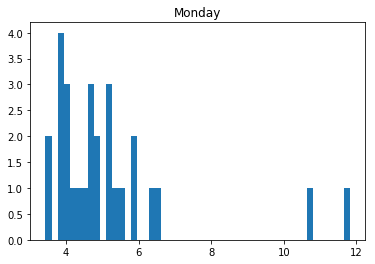

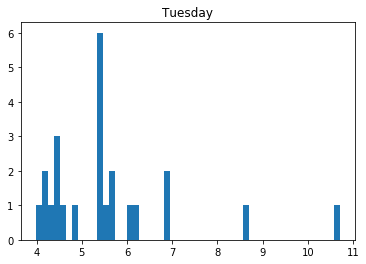

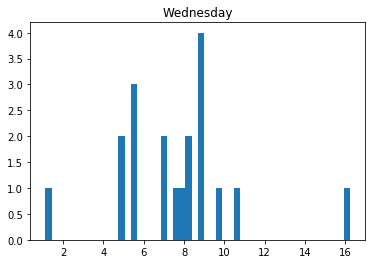

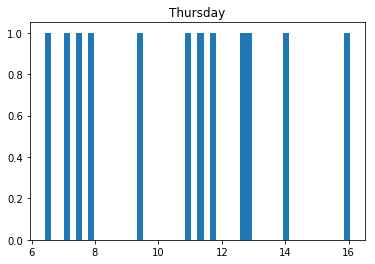

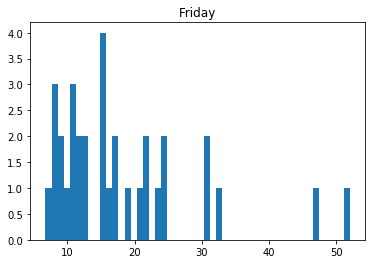

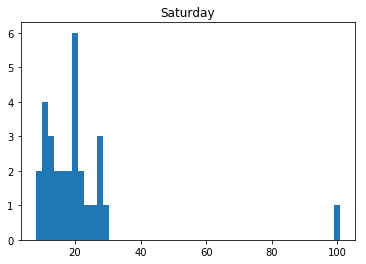

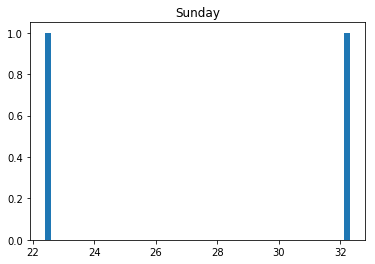

In [181]:
# identify outliers
for w in stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique():
    stats.loc[((stats['Weekday']==w)&(stats['Completed']==True)),'Minutes Spent Solving'].hist(grid=False,bins=50)
    plt.title(w)
    plt.show()
    
# clear outlier where solve time < 2 min

In [182]:
# remove outliers
print(stats.shape)
stats = stats.loc[((stats['Completed']==False)|(stats['Minutes Spent Solving']>2))]
print(stats.shape)

(184, 8)
(183, 8)


## Part 2: Basic Plots by Weekday

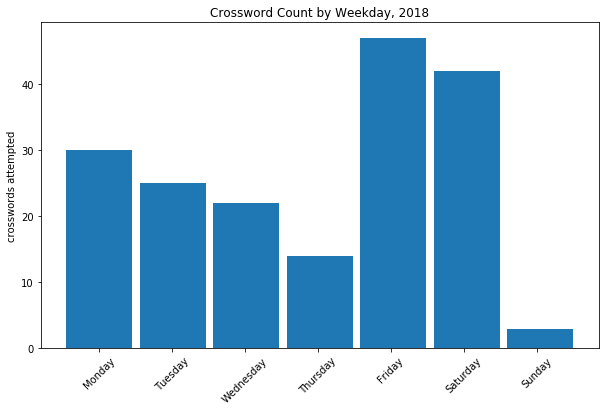

In [183]:
# Histogram of weekdays
ax = stats['Weekday (Numeric)'].hist(figsize=(10,6),bins=7,grid=False,xrot=45,align='left',rwidth=0.9)
ax.set_xticks([i*0.85 for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Crossword Count by Weekday, 2018')
plt.ylabel('crosswords attempted')
plt.show()

In [184]:
# a bigger groupby for weekdays
weekday_stats = stats.groupby(by=['Weekday (Numeric)','Completed']).agg({ 'Completed' : ['count'],
                                                                          'Minutes Spent Solving' : ['mean','min']
                                                                        })
weekday_stats

Completed Minutes Spent Solving           
                                count                  mean        min
Weekday (Numeric) Completed                                           
0                 False             2              2.891667   0.633333
                  True             28              5.182143   3.433333
1                 False             1              1.750000   1.750000
                  True             24              5.563889   3.983333
2                 False             4              7.879167   1.883333
                  True             18              8.041667   4.866667
3                 False             2              9.300000   8.283333
                  True             12             10.645833   6.433333
4                 False            14             17.116667   9.233333
                  True             33             18.268182   6.733333
5                 False            12             16.500000   1.250000
                  True             30             20.778889   8.033333
6                 False             1              0.150000   0.150000
                  True              2             27.350000  22.400000

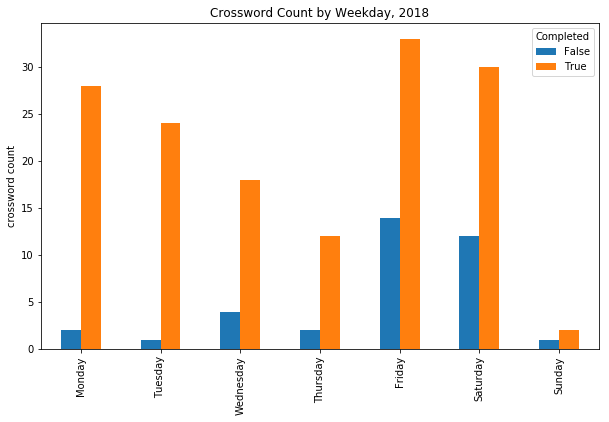

In [185]:
ax = weekday_stats.unstack()['Completed']['count'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Crossword Count by Weekday, 2018')
plt.ylabel('crossword count')
plt.xlabel('')
plt.show()

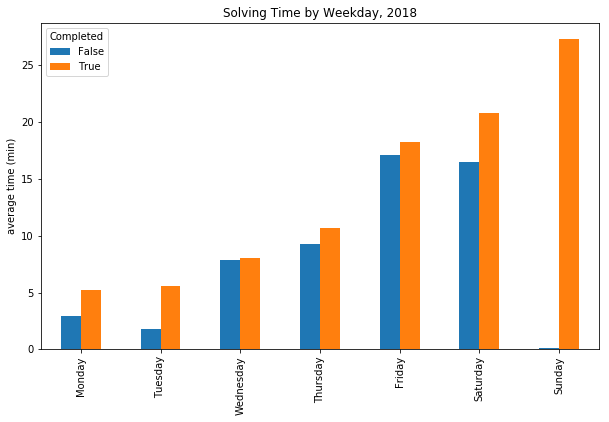

In [189]:
ax = weekday_stats.unstack()['Minutes Spent Solving']['mean'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Solving Time by Weekday, 2018')
plt.ylabel('average time (min)')
plt.xlabel('')
plt.show()

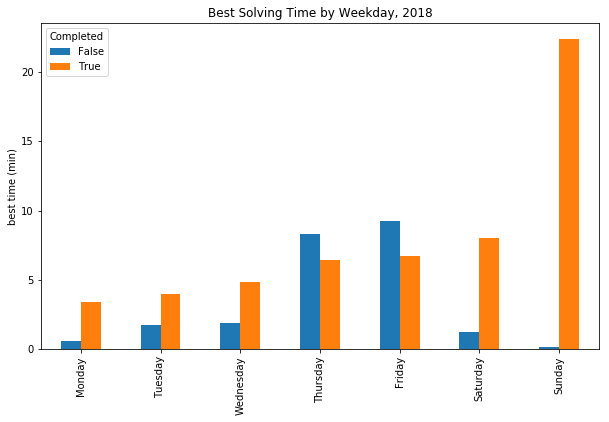

In [190]:
ax = weekday_stats.unstack()['Minutes Spent Solving']['min'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Best Solving Time by Weekday, 2018')
plt.ylabel('best time (min)')
plt.xlabel('')
plt.show()

## Part 3: When did I solve them?

In [215]:
stats['Weekday Opened (Numeric)'] = stats['First Opened'].apply(get_weekday)
stats['Weekday Opened'] = stats['First Opened'].apply(get_weekday, numeric=False)
stats['Relative Day Opened'] = stats['First Opened'].apply(datetime.date) - stats['Puzzle Date'].apply(datetime.date)
stats['Time of Day Opened'] = stats['First Opened'].apply(datetime.time)
stats['Hour of Day Opened'] = stats['Time of Day Opened'].apply(lambda x: x.hour)

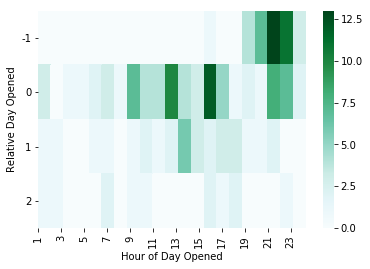

In [266]:
time_stats = stats.loc[stats['Relative Day Opened']<=timedelta(days=2)].groupby(by=['Relative Day Opened','Hour of Day Opened']).agg({'Completed':'count'})
ax = sns.heatmap(time_stats.unstack(fill_value = 0), cmap="BuGn")
ax.set_xticks([i*0.9 for i in range(24) if math.floor(i/2)*2==i])
ax.set_xticklabels([i+1 for i in range(24) if math.floor(i/2)*2==i])
ax.set_yticklabels([i-1 for i in range(9)])
plt.xlabel('Hour of Day Opened')
plt.show()

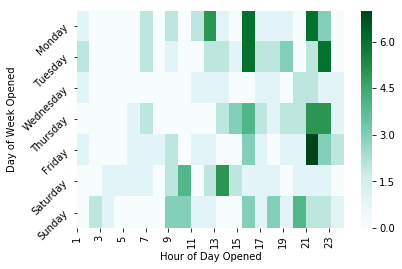

In [274]:
time_stats_abs = stats.groupby(by=['Weekday Opened (Numeric)','Hour of Day Opened']).agg({'Completed':'count'})
ax = sns.heatmap(time_stats_abs.unstack(fill_value = 0), cmap="BuGn")
ax.set_xticks([i*0.9 for i in range(24) if math.floor(i/2)*2==i])
ax.set_xticklabels([i+1 for i in range(24) if math.floor(i/2)*2==i])
ax.set_yticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
for tick in ax.get_yticklabels():
    tick.set_rotation(45)
plt.xlabel('Hour of Day Opened')
plt.ylabel('Day of Week Opened')
plt.show()